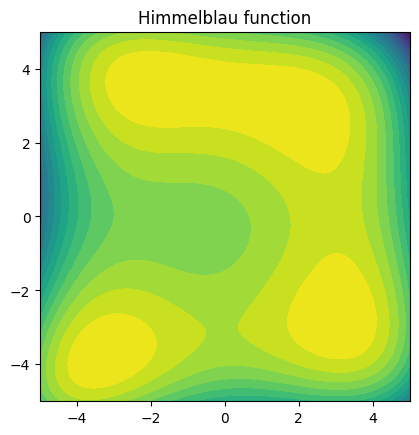

In [1]:
import matplotlib.pyplot as plt
import torch


def himmelblau(x: torch.Tensor):
    return -((x[:, 0] ** 2 + x[:, 1] - 11) ** 2 + (x[:, 0] + x[:, 1] ** 2 - 7) ** 2)


bounds = torch.tensor([[-5.0, -5.0], [5.0, 5.0]], dtype=torch.float64)
x = torch.linspace(bounds[0, 0], bounds[1, 0], 500)
y = torch.linspace(bounds[0, 1], bounds[1, 1], 500)
xy = torch.cartesian_prod(x, y)
z = himmelblau(xy).view(500, 500)

plt.contourf(x, y, z, levels=20)
plt.title("Himmelblau function")
plt.gca().set_aspect("equal")

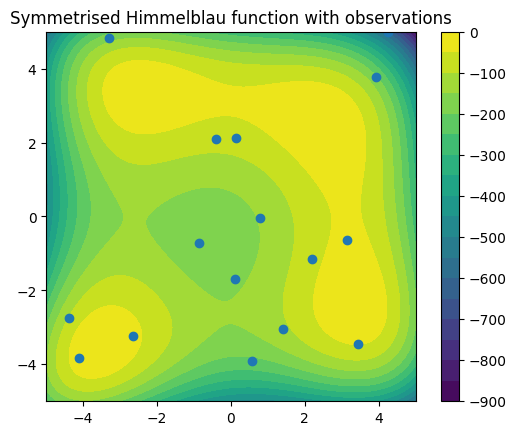

In [2]:
from torch.distributions.uniform import Uniform

torch.manual_seed(1)


def symmetrised(f):
    def g(x):
        return 0.5 * (f(x) + f(torch.flip(x, [-1])))

    return g


def objective(x):
    return symmetrised(himmelblau)(x)


plt.figure()
# Function
plt.contourf(
    x,
    y,
    objective(xy).view(500, 500),
    levels=20,
)
plt.colorbar()
# Observations
n = 16
x_train = Uniform(bounds[0, 0], bounds[1, 0]).sample((n, 2))
y_train = objective(x_train)
x_train = x_train.to(dtype=torch.float64)
y_train = y_train.to(dtype=torch.float64)

plt.scatter(x_train[:, 0], x_train[:, 1])
plt.title("Symmetrised Himmelblau function with observations")
plt.gca().set_aspect("equal")

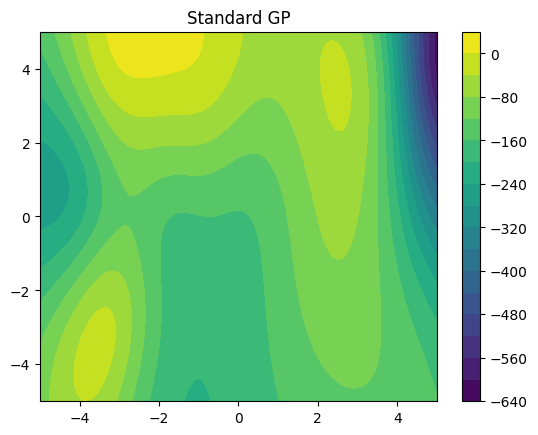

In [3]:
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize, Normalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim.fit import fit_gpytorch_mll_torch

gp = SingleTaskGP(
    x_train,
    torch.unsqueeze(y_train, -1),
    outcome_transform=Standardize(m=1),
    input_transform=Normalize(d=x_train.size(-1), bounds=bounds),
)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll_torch(mll)

with torch.no_grad():
    f = gp.posterior(xy).mean.view(500, 500)
plt.contourf(x, y, f, levels=20)
plt.colorbar()
plt.title("Standard GP")
plt.show()

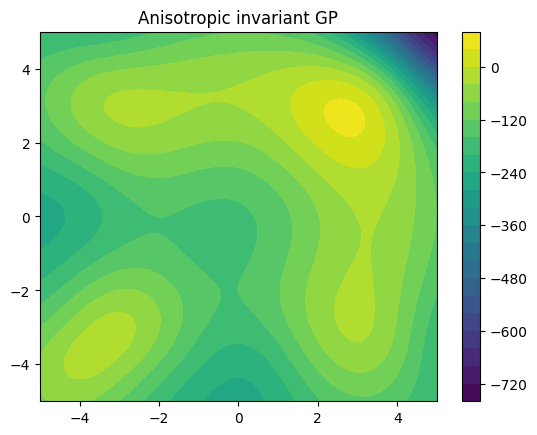

In [4]:
from gpytorch.priors.torch_priors import GammaPrior
from gpytorch.kernels import MaternKernel, ScaleKernel
from invariantkernels import (
    permutations,
    IsotropicGroupInvariantKernel,
    AnisotropicGroupInvariantKernel,
)

invariant_gp = SingleTaskGP(
    x_train,
    torch.unsqueeze(y_train, -1),
    covar_module=AnisotropicGroupInvariantKernel(
        base_kernel=ScaleKernel(
            base_kernel=MaternKernel(
                nu=2.5,
                ard_num_dims=x_train.shape[-1],
                lengthscale_prior=GammaPrior(3.0, 6.0),
            ),
            outputscale_prior=GammaPrior(2.0, 0.15),
        ),
        transformation_group=permutations,
    ),
    outcome_transform=Standardize(m=1),
    input_transform=Normalize(d=x_train.size(-1), bounds=bounds),
)
mll = ExactMarginalLogLikelihood(invariant_gp.likelihood, invariant_gp)
fit_gpytorch_mll_torch(mll)

with torch.no_grad():
    f = invariant_gp.posterior(xy).mean.view(500, 500)
plt.contourf(x, y, f, levels=20)
plt.colorbar()
plt.title("Anisotropic invariant GP")
plt.show()

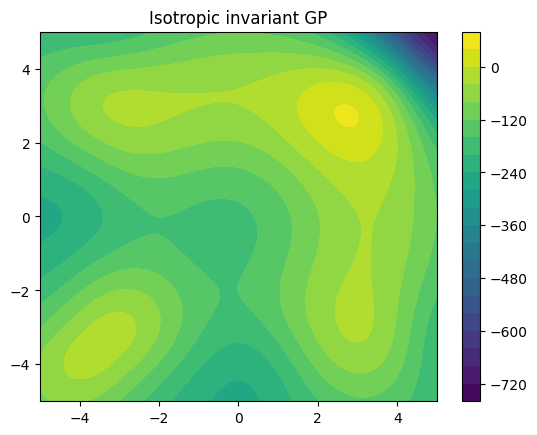

In [5]:
from gpytorch.priors.torch_priors import GammaPrior
from gpytorch.kernels import MaternKernel, ScaleKernel
from invariantkernels import (
    permutations,
    IsotropicGroupInvariantKernel,
    AnisotropicGroupInvariantKernel,
)

invariant_gp = SingleTaskGP(
    x_train,
    torch.unsqueeze(y_train, -1),
    covar_module=IsotropicGroupInvariantKernel(
        base_kernel=ScaleKernel(
            base_kernel=MaternKernel(
                nu=2.5,
                # ard_num_dims=x_train.shape[-1],
                ard_num_dims=1,
                lengthscale_prior=GammaPrior(3.0, 6.0),
            ),
            outputscale_prior=GammaPrior(2.0, 0.15),
        ),
        transformation_group=permutations,
    ),
    outcome_transform=Standardize(m=1),
    input_transform=Normalize(d=x_train.size(-1), bounds=bounds),
)
mll = ExactMarginalLogLikelihood(invariant_gp.likelihood, invariant_gp)
fit_gpytorch_mll_torch(mll)

with torch.no_grad():
    f = invariant_gp.posterior(xy).mean.view(500, 500)
plt.contourf(x, y, f, levels=20)
plt.colorbar()
plt.title("Isotropic invariant GP")
plt.show()